In [1]:
from itertools import product

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from graspologic.embed import select_dimension, AdjacencySpectralEmbed
from graspologic.inference import latent_distribution_test
from graspologic.plot import heatmap
from graspologic.simulations import rdpg
from graspologic.utils import fit_plug_in_variance_estimator

from hyppo.ksample import KSample
from hyppo._utils import gaussian

from joblib import Parallel, delayed

from scipy.stats import multivariate_normal
from tqdm import tqdm

from utils import load_data

%matplotlib inline

## Visualizing Data

In [ ]:
A_l, nodes_l, A_r, nodes_r, hemispheres = load_data()

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
heatmap(A_l, inner_hier_labels=nodes_l, hier_label_fontsize=15, sort_nodes=True, ax=ax[0], title="Left")
heatmap(A_r, inner_hier_labels=nodes_r, hier_label_fontsize=15, sort_nodes=True, ax=ax[1], title="Right")

## Code for sampling and testing

In [ ]:
def hypothesis_test(X1, X2, flip):
    tests = [KSample('Dcorr'), KSample('MGC')]
    
    if flip == 'median':
        X1_flipped = SignFlips('median').fit_transform(X1, X2)
        
    elif flip == 'seedless':
        X1_flipped = SeedlessProcrustes().fit_transform(X1, X2)        
    
    pvals = []
    for test in tests:
        res = test.test(X1_flipped, X2, auto=False)
        pvals.append(res[1])
        
    return pvals

def embed_graphs(A1, A2):
    num_dims1 = select_dimension(A1)[0][-1]
    num_dims2 = select_dimension(A2)[0][-1]
    n_components = max(num_dims1, num_dims2)
    
    ase = AdjacencySpectralEmbed(n_components=n_components, diag_aug=True, check_lcc=False)
    X1_hat = ase.fit_transform(A1)
    X2_hat = ase.fit_transform(A2)
    
    return X1_hat, X2_hat

def run_replacement(X1_hat, X2_hat, X1_verts, X2_verts, n_verts_to_perterb, delta, n_sims=500):
    """
    delta is non-negative number
    """
    d = X1_hat.shape[1]
    N = X1_hat.shape[0]
    M = X2_hat.shape[0]
    
    X1_cov = fit_plug_in_variance_estimator(X1_hat)(X1_hat) / N
    X2_cov = fit_plug_in_variance_estimator(X2_hat)(X2_hat) / M
    
    def worker():    
        # Sample new latents
        X1_new = []
        verts_to_perterb = np.random.choice(range(X1_verts), size=n_verts_to_perterb, replace=False)
        
        X1_idx = np.random.choice(range(N), size=X1_verts, replace=True)
        X2_idx = np.random.choice(range(M), size=X2_verts, replace=True)
        
        X1_hat_replaced = X1_hat[X1_idx]
        X2_hat_replaced = X2_hat[X2_idx]
        
        X1_cov_replaced = X1_cov[X1_idx]
        X2_cov_replaced = X2_cov[X2_idx]
        
        for idx in range(X1_verts):
            if idx in verts_to_perterb:
                direction = multivariate_normal.rvs(cov=np.eye(d), random_state=np.random.randint(2147483647))
                direction /= np.linalg.norm(direction)
                shift = direction * delta
                
                mean = X1_hat_replaced[idx] + shift
            else:
                mean = X1_hat_replaced[idx]

            X1_new.append(
                multivariate_normal.rvs(
                    mean,
                    X1_cov_replaced[idx], 
                    random_state=np.random.randint(2147483647)
                )
            )
        X1_new = np.array(X1_new)
        X2_new = np.array(
            [
                multivariate_normal.rvs(
                    X2_hat_replaced[idx], 
                    X2_cov_replaced[idx], 
                    random_state=np.random.randint(2147483647)
                ) for idx in range(X2_verts)
            ]
        )
        
        # Sample new graphs
        A1 = rdpg(X1_new, rescale=False)
        A2 = rdpg(X2_new, rescale=False)
        X1_resampled, X2_resampled = embed_graphs(A1, A2)
        
        # Compute pvals
        pvals_median = hypothesis_test(X1_resampled, X2_resampled, "median")
        pvals_seedless = hypothesis_test(X1_resampled, X2_resampled, "seedless")
        
        return np.hstack([pvals_median, pvals_seedless])
    
    res = Parallel(-1, verbose=0)(delayed(worker)() for _ in range(n_sims))
    
    res = np.array(res)
    power = (res <= 0.05).mean(axis=0)
    
    return [X1_verts, X2_verts, n_verts_to_perterb, delta, *power]

## Parameters

In [ ]:
deltas = np.array([.5, 1])
rho = np.array([0, .5, 1])

X1_hat, X2_hat = embed_graphs(A_l, A_r)

n_verts = np.tile(np.linspace(0, 200, 11)[1:], 3).astype(int) # 20 - 200

n_verts_to_perterbs = n_verts.reshape(3, 10) * rho.reshape(-1, 1)
n_verts_to_perterbs = n_verts_to_perterbs.reshape(-1).astype(int)

args = [
    dict(n_verts_to_perterb=n_verts_to_perterb, delta=delta, X1_verts=n_vert, X2_verts=n_vert) 
    for (n_vert, n_verts_to_perterb), delta 
    in product(zip(n_verts, n_verts_to_perterbs), deltas)
]

cols = ["x1_verts", "x2_verts", "n_verts_perterbed", "delta", "dcorr_median", "mgc_median", "dcorr_opt", "mgc_opt"]

### Do left replacement

In [ ]:
res = []

for arg in tqdm(args):
    tmp = run_replacement(X1_hat, X1_hat, **arg)
    res.append(tmp)

df = pd.DataFrame(res, columns=cols)
df.to_csv("./results/figure2_left.csv", index=False)

### Do right replacement

In [ ]:
res = []

for arg in tqdm(args):
    tmp = run_replacement(X2_hat, X2_hat, **arg)
    res.append(tmp)

df2 = pd.DataFrame(res, columns=cols)
df2.to_csv("./results/figure2_right.csv", index=False)

### Plot

In [2]:
csvs = [
    "./results/figure2_left.csv",
    "./results/figure2_right.csv"
]

dfs = [pd.read_csv(csv) for csv in csvs]

for df in dfs:
    df["prop_perterbed"] = df["n_verts_perterbed"] / df["x1_verts"]

legends = ["dcorr_median", "mgc_median", "dcorr_seedless", "mgc_seedless"]
legend_names = dict(
    dcorr_median = "DCorr+Median",
    mgc_median = "MGC+Median",
    dcorr_seedless = "DCorr+OTP",
    mgc_seedless = "MGC+OTP"
)

row_titles = [
    "Left Brain",
    "Right Brain",
]

No handles with labels found to put in legend.
No handles with labels found to put in legend.


(11.0, 209.0, -0.05160924955153417, 1.0500766309310254)

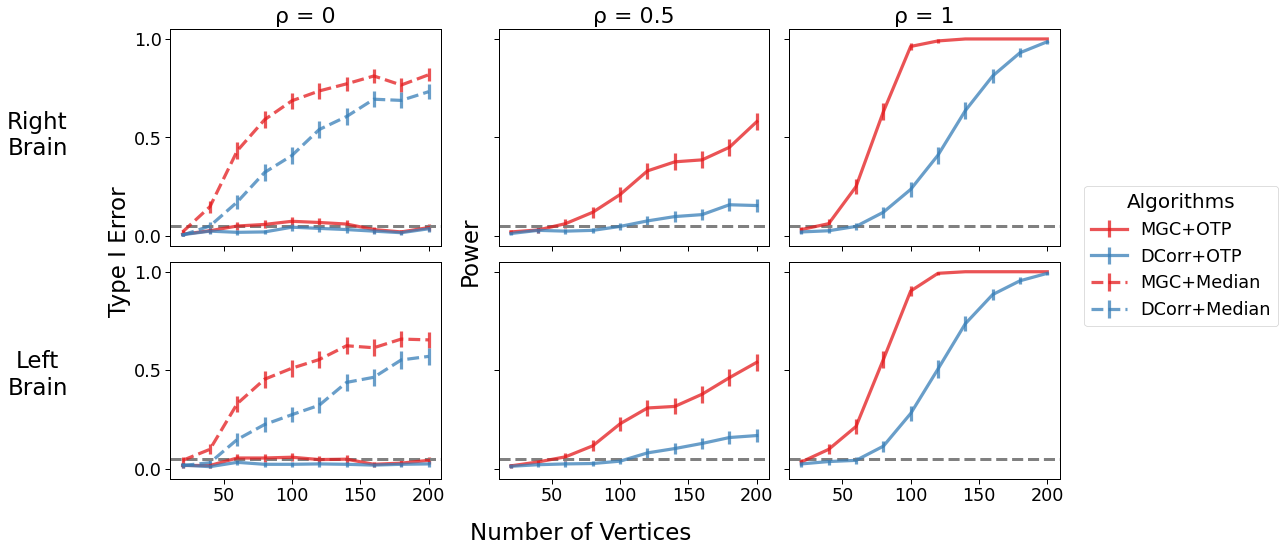

In [3]:
import matplotlib.transforms as mtransforms

sns.set_context('paper', font_scale=2, rc={"lines.linewidth": 3})
fig, ax = plt.subplots (nrows=2, ncols=4, figsize=(13, 7), constrained_layout=True, sharex=True, sharey=True,
                        gridspec_kw=dict(width_ratios=[1, .1, 1, 1])
                       )

col_titles = [
    "ρ = 0",
    "",
    "ρ = 0.5", 
    "ρ = 1"
]

algo_titles = ["MGC+OTP", "DCorr+OTP", "MGC+Median", "DCorr+Median"]
colors = ['#e41a1c','#377eb8','#e41a1c','#377eb8']
dashes = ["-", "-", "--", "--"]

xlim = (11.0, 209.0)
xs = np.linspace(*xlim)

for row, df in enumerate(dfs):
    for col, col_name in enumerate(np.unique(df.prop_perterbed)):
        if col > 0:
            col += 1
        
        tmp_df = df[(df.prop_perterbed == col_name) & (df.delta == 1)]
        tmp_df = tmp_df[["mgc_opt", "dcorr_opt","mgc_median", "dcorr_median",  "x1_verts"]]
        melted = tmp_df.melt(id_vars='x1_verts')
        
        ns = np.unique(melted.x1_verts)
        
        for jdx, algo in enumerate(["mgc_opt", "dcorr_opt","mgc_median", "dcorr_median"]):
            tmp_df = melted[melted.variable == algo]

            powers = tmp_df.value.values
            errs = 1.96 * np.sqrt(powers * (1 - powers) / 500) #1000 = num reps

            if col >= 1:
                if algo in ["mgc_median", "dcorr_median"]:
                    continue
                    
            ax[row, col].errorbar(x = ns, y=powers, yerr=errs, label=algo_titles[jdx], c=colors[jdx], alpha=0.75, ls = dashes[jdx], lw=3.2)
            
        # Set col title
        if row == 0:
            ax[row, col].set_title(col_titles[col], fontsize=22)
        
        ax[row, col].set_yticks([0, 0.5,  1])
        ax[row, col].set_xlabel("")
        
        ax[row, col].axhline(0.05, c='gray', ls='--')
        
ax[row, col].set_xlim(*xlim)

for i in range(2):
    for j in range(3):
        if (i == 0) & (j == 0):
            handles, labels = ax[i, j].get_legend_handles_labels() 
        ax[i, j].legend().remove()

legend = fig.legend(
    handles=handles,
    labels=["MGC+OTP", "DCorr+OTP", "MGC+Median", "DCorr+Median"],
    ncol = 1, 
    loc='center right',
    bbox_to_anchor=(1.235, .5),
    bbox_transform=plt.gcf().transFigure,
    title = "Algorithms",
    title_fontsize=20
)
        
fig.text(-0.025, .51, "Type I Error", rotation="vertical", va='center', fontsize=23)
fig.text(.35, .51, "Power", rotation="vertical",  va='center', fontsize=23)

fig.text(-0.1, .225, "Left\nBrain",  ha='center', fontsize=23)
fig.text(-0.1, .7, "Right\nBrain",  ha='center', fontsize=23)


fig.text(.48, -0.05, "Number of Vertices", va='center', ha='center', fontsize=23)

ax[0, 1].axis("off")
ax[1, 1].axis("off")

In [4]:
fig.savefig("./figures/figure2.pdf", bbox_inches='tight')
fig.savefig("./figures/figure2.png", bbox_inches='tight', dpi=300)